In [23]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
from keras import optimizers
from sklearn.cluster import KMeans
%matplotlib inline

In [8]:
G= nx.read_gexf('/storage/twitter_network.gexf')

In [9]:
nodes_in_credbank = []
for node in G.nodes():
    if G.node[node]['more_than_5_percent_fake'] != "b'notweets'":
        nodes_in_credbank.append(node)

In [10]:
sub_graph = G.subgraph(nodes_in_credbank)

In [17]:
real_sources = []
fake_sources = []
for node in sub_graph.nodes():
    if sub_graph.node[node]['more_than_5_percent_fake'] == "b'True'":
        fake_sources.append(node)
    else:
        real_sources.append(node)

#### Full Network Graph
![title](/storage/full_graph2.png)

#### Network Graph with Just "Fake Sources"
![title](/storage/fake_only.png)

### Network EDA

#### Eigenvector Centrality
eigenvector centrality is a measure of the influence of a node in a network. Relative scores are assigned to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores.

In [6]:
stats_from_gephi = pd.read_csv('/storage/louvain.csv')

In [7]:
ev_df = stats_from_gephi[['Id', 'eigencentrality']]
ev_df.Id = ev_df.Id.apply(lambda x: str(x))
ev_df.set_index('Id', inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
real_ev = []
fake_ev = []
for x in real_sources:
    real_ev.append(ev_df.eigencentrality.loc[x])
for x in fake_sources:
    fake_ev.append(ev_df.eigencentrality.loc[x])

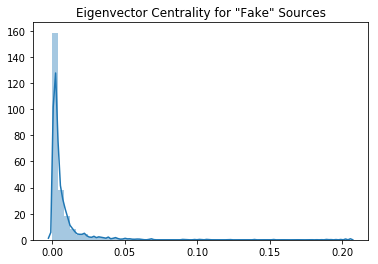

In [9]:
sns.distplot(fake_ev)
plt.title('Eigenvector Centrality for "Fake" Sources')
plt.show()

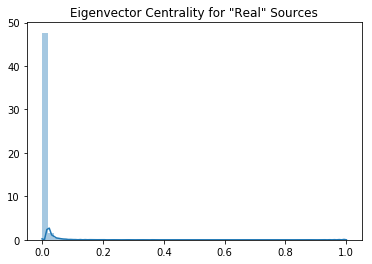

In [10]:
sns.distplot(real_ev)
plt.title('Eigenvector Centrality for "Real" Sources')
plt.show()

#### Page Rank
PageRank is widely recognized as a way of detecting influential nodes in a graph. It is different to other centrality algorithms because the influence of a node depends on the influence of its neighbours.

In [11]:
pg_rnk = nx.algorithms.pagerank(sub_graph)

In [12]:
pg_real = []
pg_fk = []
for x in real_sources:
    pg_real.append(pg_rnk[x])
for x in fake_sources:
    pg_fk.append(pg_rnk[x])

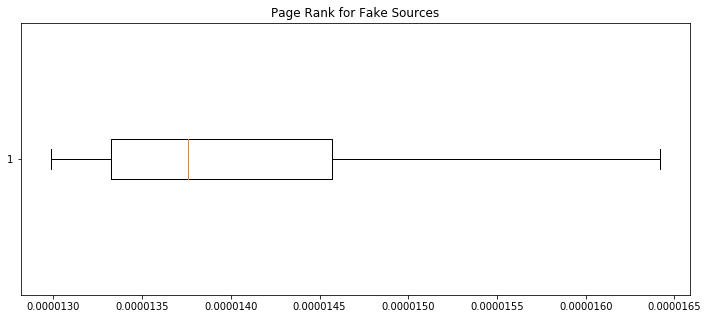

In [13]:
plt.figure(figsize=(12,5))
plt.boxplot(pg_fk, showfliers=False, vert=False)
plt.title("Page Rank for Fake Sources")
plt.show()

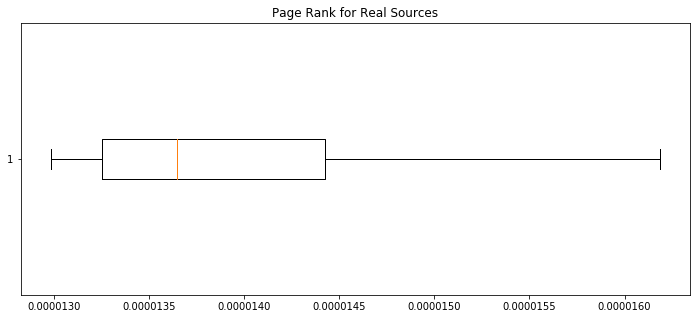

In [14]:
plt.figure(figsize=(12,5))
plt.boxplot(pg_real, showfliers=False, vert=False)
plt.title("Page Rank for Real Sources")
plt.show()

## Clustering

### Louvain Community Detection
The Louvain method of community detection is an algorithm for detecting communities in networks. It maximizes a modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities by evaluating how much more densely connected the nodes within a community are compared to how connected they would be in a random network.

![title](/storage/louvain_full.png)

![title](/storage/louvain_partition.png)

In [20]:
louvain_df = stats_from_gephi[['Id', 'Cluster']]
louvain_df.Id = louvain_df.Id.apply(lambda x: str(x))

louvain_df.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Id,Cluster
0,28835,0
1,204136,0
2,111815,171
3,36410,27
4,106949,0


In [21]:
louvain_df['Fake'] = louvain_df.Id.apply(lambda x: x in fake_sources)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
real_clusters = set(list(louvain_df[louvain_df['Fake'] == False].Cluster))
fake_clusters = set(list(louvain_df[louvain_df['Fake'] == True].Cluster))
both = real_clusters.intersection(fake_clusters)

In [24]:
total_eliminated = 0
for x in list(louvain_df[louvain_df['Fake'] == False].Cluster):
    if x not in both:
        total_eliminated +=1

In [25]:
print(f"Total real nodes eliminated through clustering: {total_eliminated}")

Total real nodes eliminated through clustering: 25838


## Node2Vec
The node2vec framework learns low-dimensional representations for nodes in a graph by optimizing a neighborhood preserving objective. The objective is flexible, and the algorithm accomodates for various definitions of network neighborhoods by simulating biased random walks. Specifically, it provides a way of balancing the exploration-exploitation tradeoff that in turn leads to representations obeying a spectrum of equivalences from homophily to structural equivalence.

In [7]:
from node2vec import Node2Vec

In [8]:
node2vec = Node2Vec(sub_graph, dimensions=128, walk_length=30, num_walks=10, workers=1)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


In [9]:
vmodel = node2vec.fit()

In [10]:
vmodel.wv.save_word2vec_format('storage/node.emb')

In [7]:
emb_df = pd.read_csv('/storage/node.emb', sep=' ', skiprows=[0], header=None)
emb_df.set_index(0, inplace=True)
emb_df.index.name = 'node'
emb_df.head()

,1,2,3,4,5,6,7,8,9,10,...,119,120,121,122,123,124,125,126,127,128
node,,,,,,,,,,,,,,,,,,,,,
34,-0.000417,0.001989,-0.004499,0.002064,0.000562,0.001108,-0.003968,-0.003315,-0.000301,0.000551,...,-0.002949,0.003850,0.000241,-0.003262,0.001365,0.000176,-0.004062,0.003646,-0.001924,0.002871
47066,-0.003729,-0.000119,0.000601,0.004229,0.003420,-0.003709,0.003611,-0.003606,-0.004380,-0.001287,...,-0.004171,-0.001042,0.002954,0.000634,0.002326,-0.002461,-0.002202,-0.003970,0.004373,0.003513
935,-0.001003,-0.002174,-0.001238,0.001964,0.001928,-0.003586,-0.003625,0.003252,-0.000097,0.002920,...,-0.002940,0.000396,0.001657,-0.002333,-0.000082,-0.002194,0.004538,0.004374,-0.000738,0.003034
2949,0.004158,0.002282,-0.001644,-0.000164,0.001070,0.000459,-0.000503,0.004645,-0.001603,0.001802,...,-0.003522,-0.001081,-0.001154,0.000867,0.000540,-0.003094,-0.002665,-0.002491,-0.001361,-0.004501
2839,-0.001071,-0.002346,-0.001869,-0.001843,0.003638,0.000234,0.003892,0.004373,0.000185,0.003958,...,-0.000363,0.000351,0.001447,0.003352,0.001120,0.000904,-0.000199,-0.000725,-0.002350,-0.004272


In [19]:
nodes = list(emb_df.index)
nodes = [str(node) for node in nodes]
target = []
real_set = set(real_sources)
for node in nodes:
    if node in real_set:
        target.append(0)
    else:
        target.append(1)

In [22]:
emb_df['target'] = target
emb_df.head()

,1,2,3,4,5,6,7,8,9,10,...,120,121,122,123,124,125,126,127,128,target
node,,,,,,,,,,,,,,,,,,,,,
34,-0.000417,0.001989,-0.004499,0.002064,0.000562,0.001108,-0.003968,-0.003315,-0.000301,0.000551,...,0.003850,0.000241,-0.003262,0.001365,0.000176,-0.004062,0.003646,-0.001924,0.002871,0
47066,-0.003729,-0.000119,0.000601,0.004229,0.003420,-0.003709,0.003611,-0.003606,-0.004380,-0.001287,...,-0.001042,0.002954,0.000634,0.002326,-0.002461,-0.002202,-0.003970,0.004373,0.003513,0
935,-0.001003,-0.002174,-0.001238,0.001964,0.001928,-0.003586,-0.003625,0.003252,-0.000097,0.002920,...,0.000396,0.001657,-0.002333,-0.000082,-0.002194,0.004538,0.004374,-0.000738,0.003034,0
2949,0.004158,0.002282,-0.001644,-0.000164,0.001070,0.000459,-0.000503,0.004645,-0.001603,0.001802,...,-0.001081,-0.001154,0.000867,0.000540,-0.003094,-0.002665,-0.002491,-0.001361,-0.004501,0
2839,-0.001071,-0.002346,-0.001869,-0.001843,0.003638,0.000234,0.003892,0.004373,0.000185,0.003958,...,0.000351,0.001447,0.003352,0.001120,0.000904,-0.000199,-0.000725,-0.002350,-0.004272,0


### K Means Clustering

In [35]:
emb_df.head()

,1,2,3,4,5,6,7,8,9,10,...,120,121,122,123,124,125,126,127,128,target
node,,,,,,,,,,,,,,,,,,,,,
34,-0.000417,0.001989,-0.004499,0.002064,0.000562,0.001108,-0.003968,-0.003315,-0.000301,0.000551,...,0.003850,0.000241,-0.003262,0.001365,0.000176,-0.004062,0.003646,-0.001924,0.002871,0
47066,-0.003729,-0.000119,0.000601,0.004229,0.003420,-0.003709,0.003611,-0.003606,-0.004380,-0.001287,...,-0.001042,0.002954,0.000634,0.002326,-0.002461,-0.002202,-0.003970,0.004373,0.003513,0
935,-0.001003,-0.002174,-0.001238,0.001964,0.001928,-0.003586,-0.003625,0.003252,-0.000097,0.002920,...,0.000396,0.001657,-0.002333,-0.000082,-0.002194,0.004538,0.004374,-0.000738,0.003034,0
2949,0.004158,0.002282,-0.001644,-0.000164,0.001070,0.000459,-0.000503,0.004645,-0.001603,0.001802,...,-0.001081,-0.001154,0.000867,0.000540,-0.003094,-0.002665,-0.002491,-0.001361,-0.004501,0
2839,-0.001071,-0.002346,-0.001869,-0.001843,0.003638,0.000234,0.003892,0.004373,0.000185,0.003958,...,0.000351,0.001447,0.003352,0.001120,0.000904,-0.000199,-0.000725,-0.002350,-0.004272,0


In [24]:
k_means = KMeans(n_clusters=10)
k_means.fit(emb_df[:-1])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
preds = k_means.predict(emb_df[:-1])

In [30]:
preds_df = emb_df[['target']]

In [32]:
len(preds)

69024

In [33]:
len(preds_df)

69025